Epoch [0/1000], Loss: 3311.9663
Epoch [100/1000], Loss: 374.0326
Epoch [200/1000], Loss: 371.8455
Epoch [300/1000], Loss: 371.4813
Epoch [400/1000], Loss: 371.1937
Epoch [500/1000], Loss: 370.7876
Epoch [600/1000], Loss: 370.5075
Epoch [700/1000], Loss: 370.2666
Epoch [800/1000], Loss: 370.2110
Epoch [900/1000], Loss: 370.0202


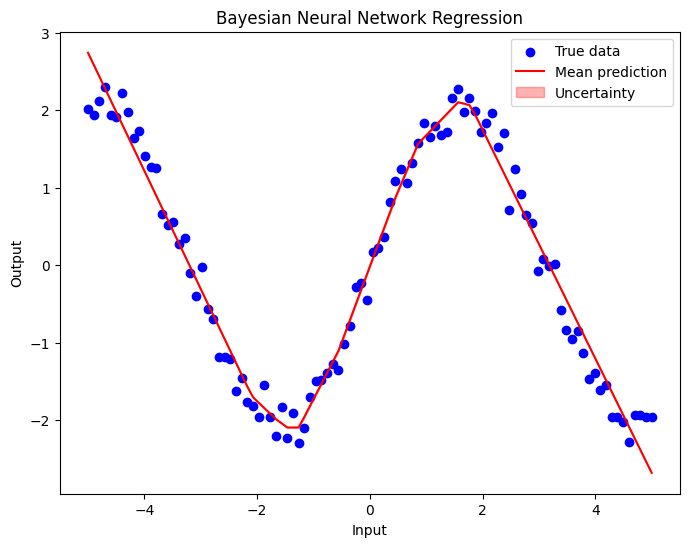

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# Gnerate toy data
np.random.seed(42)
X = np.linspace(-5, 5, 100).reshape(-1, 1)
y = 2 * np.sin(X) + np.random.normal(0, 0.2, size=X.shape)

# Conv data to tensors
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32)

# Define the BNN 
class BayesianNN(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim=50):
        super(BayesianNN, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.hidden_dim = hidden_dim

        # Define the Bayesian layers
        self.layer1 = nn.Linear(self.input_dim, self.hidden_dim)
        self.layer2 = nn.Linear(self.hidden_dim, self.output_dim)

        # Initialize weights with Gaussian priors
        self.layer1.weight.data.normal_(0, 0.1)
        self.layer1.bias.data.fill_(0)
        self.layer2.weight.data.normal_(0, 0.1)
        self.layer2.bias.data.fill_(0)

    def forward(self, x):
        x = torch.relu(self.layer1(x))
        x = self.layer2(x)
        return x

# likelihood (Gaussian)
def likelihood(y_pred, y_true, sigma=0.2):
    return torch.distributions.normal.Normal(y_pred, sigma).log_prob(y_true).sum()

# prior (Gaussian)
def prior(model, sigma=1):
    log_prior = 0
    for param in model.parameters():
        log_prior += torch.distributions.normal.Normal(0, sigma).log_prob(param).sum()
    return log_prior

# Dposterior
def posterior(model, sigma=0.1):
    log_posterior = 0
    for param in model.parameters():
        log_posterior += torch.distributions.normal.Normal(param, sigma).log_prob(param).sum()
    return log_posterior

#  loss function as  negative log posterior
def loss_function(y_pred, y_true, model):
    nll = - (likelihood(y_pred, y_true) + prior(model) - posterior(model))
    return nll

# Initialize the BNN model
bnn_model = BayesianNN(input_dim=1, output_dim=1)

# 
optimizer = optim.Adam(bnn_model.parameters(), lr=0.01)

# Training loop
num_epochs = 1000
for epoch in range(num_epochs):
    optimizer.zero_grad()
    y_pred = bnn_model(X_tensor)
    loss = loss_function(y_pred, y_tensor, bnn_model)
    loss.backward()
    optimizer.step()
    if epoch % 100 == 0:
        print(f"Epoch [{epoch}/{num_epochs}], Loss: {loss.item():.4f}")

# predictions with uncertainty
with torch.no_grad():
    bnn_model.eval()
    y_pred = bnn_model(X_tensor)
    samples = [bnn_model(X_tensor) for _ in range(1000)]
    mean = torch.mean(torch.stack(samples), dim=0)
    std = torch.std(torch.stack(samples), dim=0)


plt.figure(figsize=(8, 6))
plt.scatter(X, y, label='True data', color='blue')
plt.plot(X, mean, label='Mean prediction', color='red')
plt.fill_between(X.squeeze(), (mean - 2 * std).squeeze(), (mean + 2 * std).squeeze(), alpha=0.3, color='red', label='Uncertainty')
plt.xlabel('Input')
plt.ylabel('Output')
plt.title('Bayesian Neural Network Regression')
plt.legend()
plt.show()

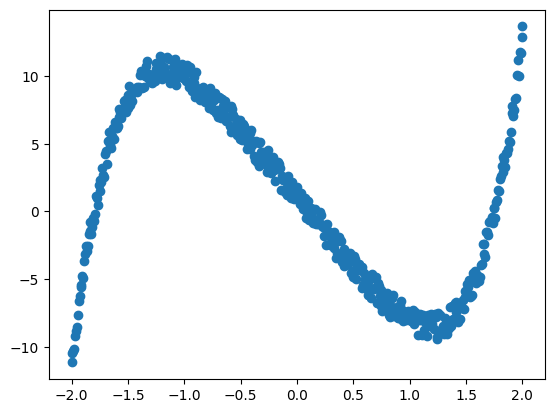

- MSE : 0.47, KL : 11.33


Text(0, 0.5, 'y')

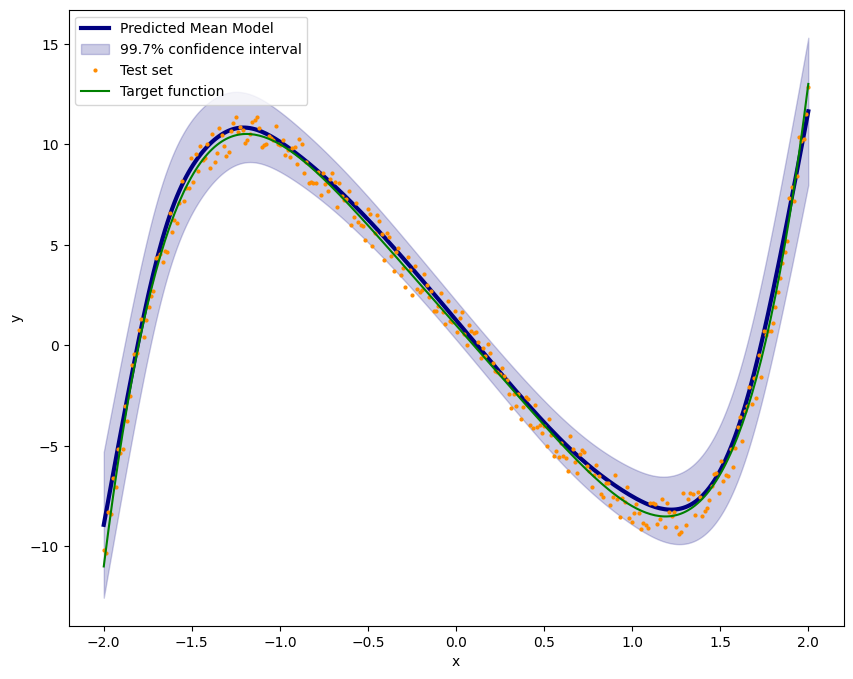

In [2]:
import numpy as np
from sklearn import datasets
import torch
import torch.nn as nn
import torch.optim as optim
import torchbnn as bnn
import matplotlib.pyplot as plt

x = torch.linspace(-2, 2, 500)
y = x.pow(5) -10* x.pow(1) + 2*torch.rand(x.size())
x = torch.unsqueeze(x, dim=1)
y = torch.unsqueeze(y, dim=1)

plt.scatter(x.data.numpy(), y.data.numpy())
plt.show()

def clean_target(x):
    return x.pow(5) -10* x.pow(1)+1
def target(x):
    return x.pow(5) -10* x.pow(1) + 2*torch.rand(x.size())

model = nn.Sequential(
    bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=1, out_features=1000),
    nn.ReLU(),
    bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=1000, out_features=1),
)

mse_loss = nn.MSELoss()
kl_loss = bnn.BKLLoss(reduction='mean', last_layer_only=False)
kl_weight = 0.01

optimizer = optim.Adam(model.parameters(), lr=0.01)

for step in range(2000):
    pre = model(x)
    mse = mse_loss(pre, y)
    kl = kl_loss(model)
    cost = mse + kl_weight*kl
    
    optimizer.zero_grad()
    cost.backward()
    optimizer.step()
    
print('- MSE : %2.2f, KL : %2.2f' % (mse.item(), kl.item()))

x_test = torch.linspace(-2, 2, 300)
y_test = target(x_test)

x_test = torch.unsqueeze(x_test, dim=1)
y_test = torch.unsqueeze(y_test, dim=1)

models_result = np.array([model(x_test).data.numpy() for k in range(10000)])
models_result = models_result[:,:,0]    
models_result = models_result.T
mean_values = np.array([models_result[i].mean() for i in range(len(models_result))])
std_values = np.array([models_result[i].std() for i in range(len(models_result))])

plt.figure(figsize=(10,8))
plt.plot(x_test.data.numpy(),mean_values,color='navy',lw=3,label='Predicted Mean Model')
plt.fill_between(x_test.data.numpy().T[0],mean_values-3.0*std_values,mean_values+3.0*std_values,alpha=0.2,color='navy',label='99.7% confidence interval')
#plt.plot(x_test.data.numpy(),mean_values,color='darkorange')
plt.plot(x_test.data.numpy(),y_test.data.numpy(),'.',color='darkorange',markersize=4,label='Test set')
plt.plot(x_test.data.numpy(),clean_target(x_test).data.numpy(),color='green',markersize=4,label='Target function')
plt.legend()
plt.xlabel('x')
plt.ylabel('y')

In [6]:
import pandas as pd 
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchbnn as bnn
adt = pd.read_csv("../../DARE-parker-challenge/engineered_data/assay_desurveyed_transformed_Mlith_domain.csv")
domained = pd.read_csv('../../DARE-parker-challenge/engineered_data/blockmodel_domained_NN.csv')

columns_to_replace = adt.columns[17:31]
adt[columns_to_replace] = adt[columns_to_replace].replace(0, np.nan)
mineral = 'Cu_pct'
adt_Cu= adt.loc[:,["HOLEID", 'EAST_mid_tf', 'NORTH_mid_tf', 'RL_mid_tf', mineral]]

adt_Cu = adt_Cu.dropna(subset=[mineral])

counts = adt['HOLEID'].value_counts()
mask = adt['HOLEID'].isin(counts[counts > 40].index) & ~adt['Cu_pct'].isna()
result = adt[mask]
adt_Cu2 = adt_Cu

In [10]:
adt_Cu

,HOLEID,EAST_mid_tf,NORTH_mid_tf,RL_mid_tf,Cu_pct
28594,OTD461,1280.839117,1154.708898,1224.930864,0.061
28595,OTD461,1280.276957,1155.381127,1223.133185,0.113
28596,OTD461,1279.714972,1156.053609,1221.335544,0.268
28597,OTD461,1279.153161,1156.726345,1219.537944,0.770
28598,OTD461,1278.591522,1157.399335,1217.740385,0.178
...,...,...,...,...,...
28756,OTD461,1190.493975,1267.323492,934.886250,0.693
28757,OTD461,1189.930876,1268.044454,933.107456,0.303
28758,OTD461,1189.367587,1268.765765,931.328857,0.726
28759,OTD461,1188.804106,1269.487425,929.550453,1.005


In [12]:
hole = 'OTD461'
adt_Cu = adt_Cu2.loc[adt_Cu2['HOLEID'] == hole]

from sklearn.preprocessing import MinMaxScaler

# Create a MinMaxScaler instance
scaler = MinMaxScaler()

# Fit the scaler to your data and transform the specified columns
adt_Cu[['RL_mid_tf', 'Cu_pct']] = scaler.fit_transform(adt_Cu[['RL_mid_tf', 'Cu_pct']])

x = adt_Cu[['EAST_mid_tf','NORTH_mid_tf', 'RL_mid_tf']].values[:,np.newaxis] #[:,np.newaxis] makes the second dimension explicit
y = adt_Cu[mineral].values[:,np.newaxis] #[:,np.newaxis] makes the second dimension explicit
x = x.reshape(len(adt_Cu),3)
x = x[:,2].reshape(-1,1)

C:\Users\23478671\AppData\Local\Temp\ipykernel_16128\3306277643.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adt_Cu[['RL_mid_tf', 'Cu_pct']] = scaler.fit_transform(adt_Cu[['RL_mid_tf', 'Cu_pct']])


In [13]:
x = torch.tensor(x)
y = torch.tensor(y)
x = x.to(torch.float32)
y = y.to(torch.float32)


In [14]:
# Determine the size of the test set (e.g., 20% of the data)
test_size = int(0.5 * len(x))

# Generate random indices for the test set
test_indices = np.random.choice(len(x), size=test_size, replace=False)

# Create train and test sets based on the indices
x_train = x[np.setdiff1d(np.arange(len(x)), test_indices)]
y_train = y[np.setdiff1d(np.arange(len(y)), test_indices)]

x_test = x[np.sort(test_indices)]
y_test = y[np.sort(test_indices)]

In [21]:
model = nn.Sequential(
    bnn.BayesLinear(prior_mu=1, prior_sigma=0.1, in_features=1, out_features=100),
    nn.ReLU(),
    bnn.BayesLinear(prior_mu=1, prior_sigma=0.1, in_features=100, out_features=1),
)

mse_loss = nn.MSELoss()
kl_loss = bnn.BKLLoss(reduction='mean', last_layer_only=False)
kl_weight = 0.01

optimizer = optim.SGD(model.parameters(), lr=0.01)

for step in range(2000):
    pre = model(x_train)
    mse = mse_loss(pre, y_train)
    kl = kl_loss(model)
    cost = mse + kl_weight*kl
    
    optimizer.zero_grad()
    cost.backward()
    optimizer.step()
    
print('- MSE : %2.2f, KL : %2.2f' % (mse.item(), kl.item()))

- MSE : 0.24, KL : 57.67


<Figure size 1400x800 with 0 Axes>

Text(0.5, 1.0, 'OTD461')

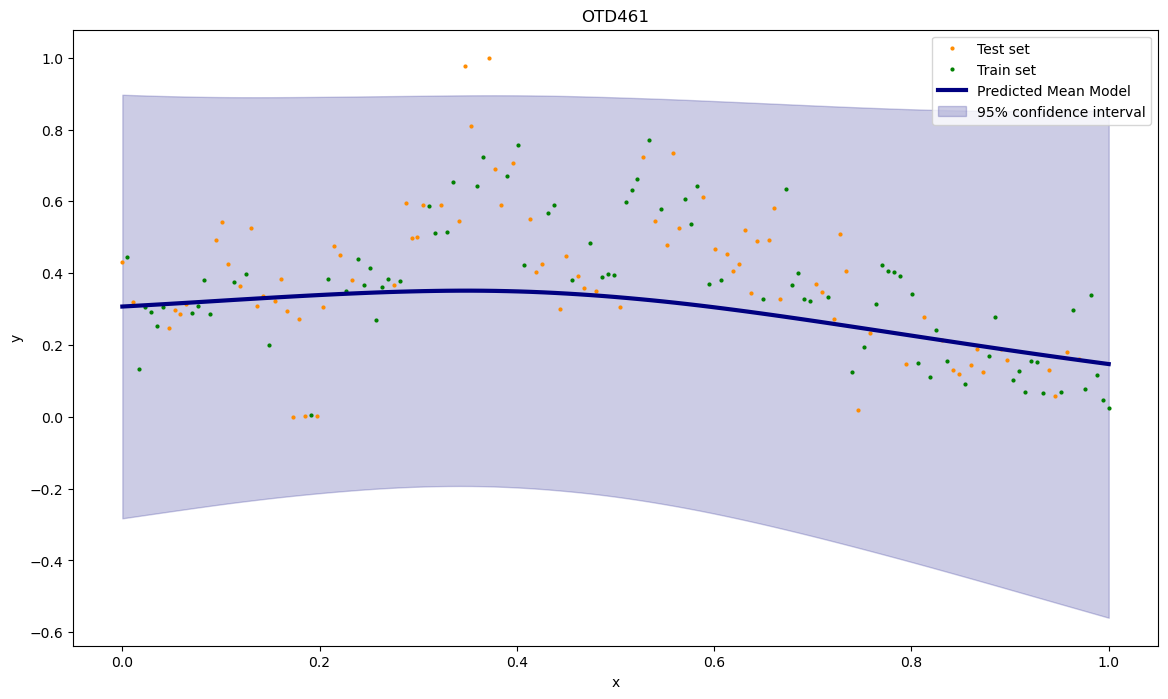

In [22]:
import matplotlib.pyplot as plt
#models_result = np.array([model(x_test).data.numpy() for k in range(1000)])
original_tensor = torch.linspace(0, 1, len(x_test))

# Reshape it to (170, 1)
reshaped_tensor = original_tensor.view(len(x_test), 1)
models_result = np.array([model(reshaped_tensor).data.numpy() for k in range(1000)])

models_result = models_result[:,:,0]    
models_result = models_result.T
mean_values = np.array([models_result[i].mean() for i in range(len(models_result))])
std_values = np.array([models_result[i].std() for i in range(len(models_result))])

plt.figure(figsize=(14,8))
#plt.scatter(x.data.numpy(), y.data.numpy(), s=4)
plt.show()

plt.figure(figsize=(14,8))
plt.plot(x_test.data.numpy()[:,0],y_test.data.numpy()[:,0],'.',color='darkorange',markersize=4,label='Test set')
plt.plot(x_train.data.numpy()[:,0],y_train.data.numpy()[:,0],'.',color='green',markersize=4,label='Train set')


plt.plot(reshaped_tensor.data.numpy()[:,0],mean_values,color='navy',lw=3,label='Predicted Mean Model')
plt.fill_between(reshaped_tensor.data.numpy()[:,0] ,mean_values-2.0*std_values,mean_values+2.0*std_values,alpha=0.2,color='navy',label='95% confidence interval')

plt.legend()
plt.xlabel('x')
plt.ylabel('y')
plt.title(hole)

In [ ]:
import pandas as pd 
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchbnn as bnn
adt = pd.read_csv("../../DARE-parker-challenge/engineered_data/assay_desurveyed_transformed_Mlith_domain.csv")
domained = pd.read_csv('../../DARE-parker-challenge/engineered_data/blockmodel_domained_NN.csv')

columns_to_replace = adt.columns[17:31]
adt[columns_to_replace] = adt[columns_to_replace].replace(0, np.nan)
mineral = 'Cu_pct'
adt_Cu= adt.loc[:,["HOLEID", 'EAST_mid_tf', 'NORTH_mid_tf', 'RL_mid_tf', mineral]]

adt_Cu = adt_Cu.dropna(subset=[mineral])

counts = adt['HOLEID'].value_counts()
mask = adt['HOLEID'].isin(counts[counts > 40].index) & ~adt['Cu_pct'].isna()
result = adt[mask]
adt_Cu2 = adt_Cu

C:\Users\23478671\AppData\Local\Temp\ipykernel_16128\1501408209.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adt_Cu[['RL_mid_tf', 'Cu_pct']] = scaler.fit_transform(adt_Cu[['RL_mid_tf', 'Cu_pct']])


- MSE : 0.05, KL : 139.44


<Figure size 1400x800 with 0 Axes>

C:\Users\23478671\AppData\Local\Temp\ipykernel_16128\1501408209.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adt_Cu[['RL_mid_tf', 'Cu_pct']] = scaler.fit_transform(adt_Cu[['RL_mid_tf', 'Cu_pct']])


- MSE : 0.18, KL : 109.00


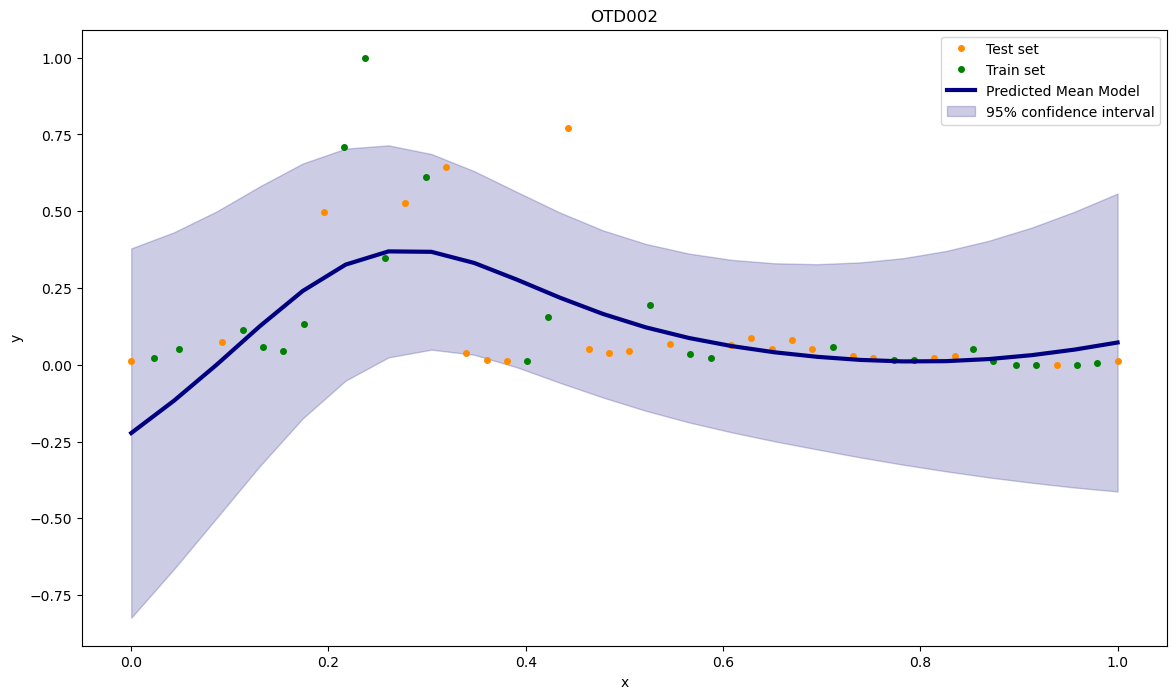

<Figure size 1400x800 with 0 Axes>

C:\Users\23478671\AppData\Local\Temp\ipykernel_16128\1501408209.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adt_Cu[['RL_mid_tf', 'Cu_pct']] = scaler.fit_transform(adt_Cu[['RL_mid_tf', 'Cu_pct']])


- MSE : 0.06, KL : 109.29


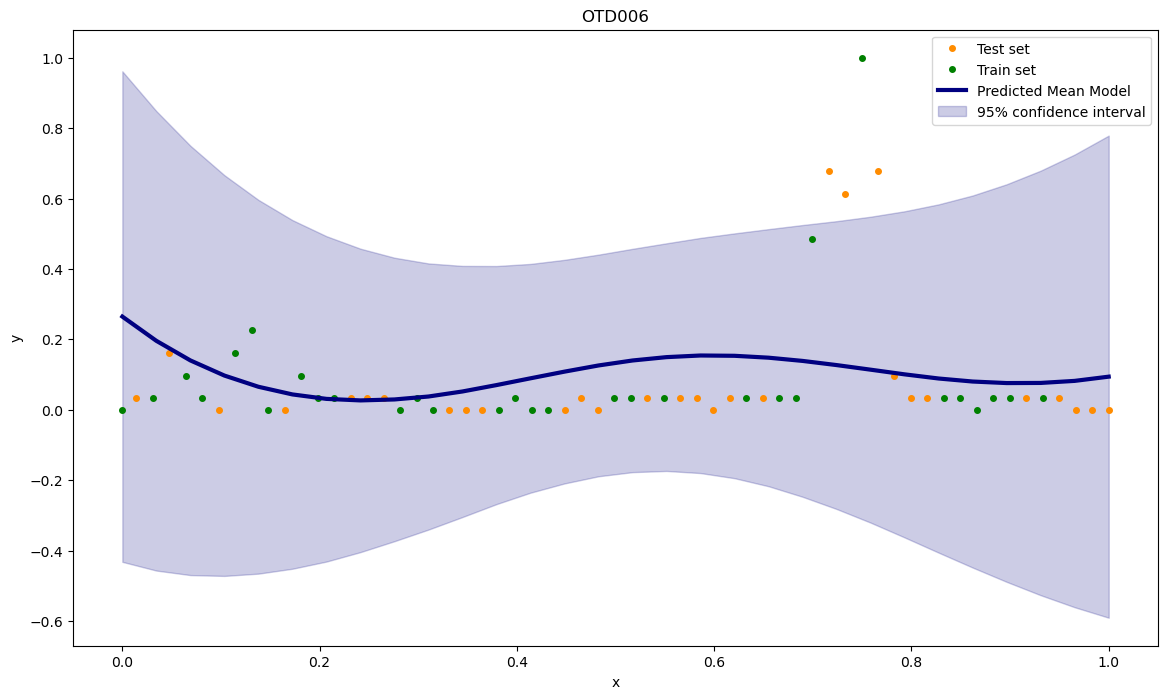

<Figure size 1400x800 with 0 Axes>

C:\Users\23478671\AppData\Local\Temp\ipykernel_16128\1501408209.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adt_Cu[['RL_mid_tf', 'Cu_pct']] = scaler.fit_transform(adt_Cu[['RL_mid_tf', 'Cu_pct']])


- MSE : 0.05, KL : 113.90


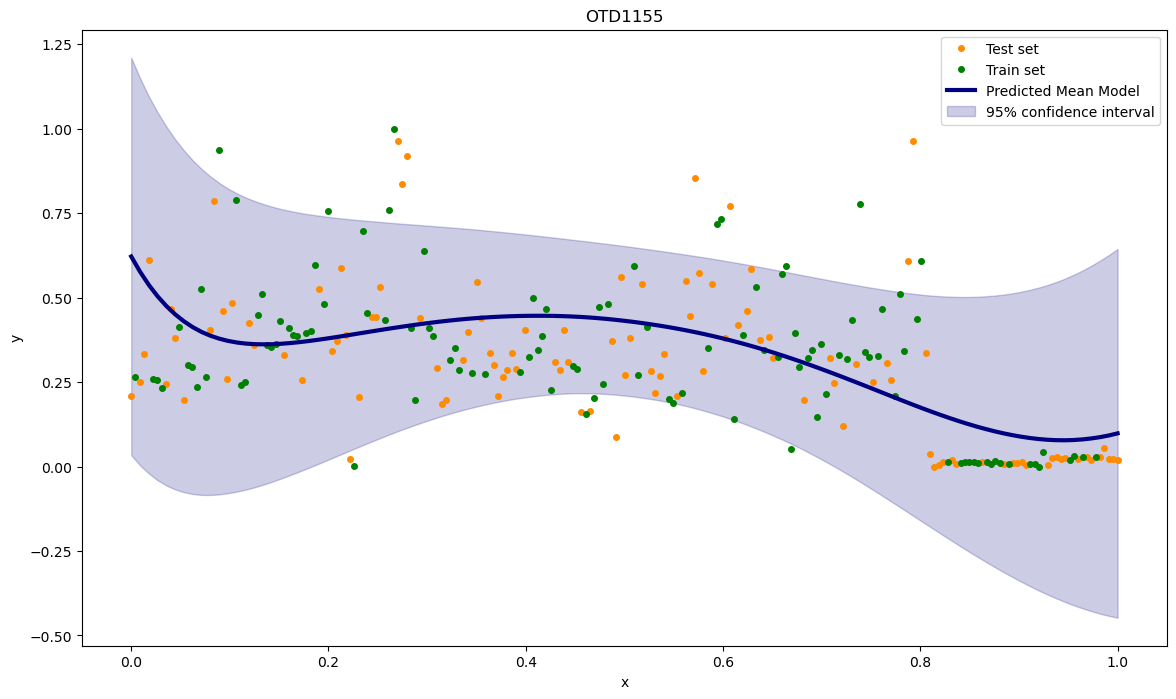

<Figure size 1400x800 with 0 Axes>

C:\Users\23478671\AppData\Local\Temp\ipykernel_16128\1501408209.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adt_Cu[['RL_mid_tf', 'Cu_pct']] = scaler.fit_transform(adt_Cu[['RL_mid_tf', 'Cu_pct']])


- MSE : 0.08, KL : 111.76


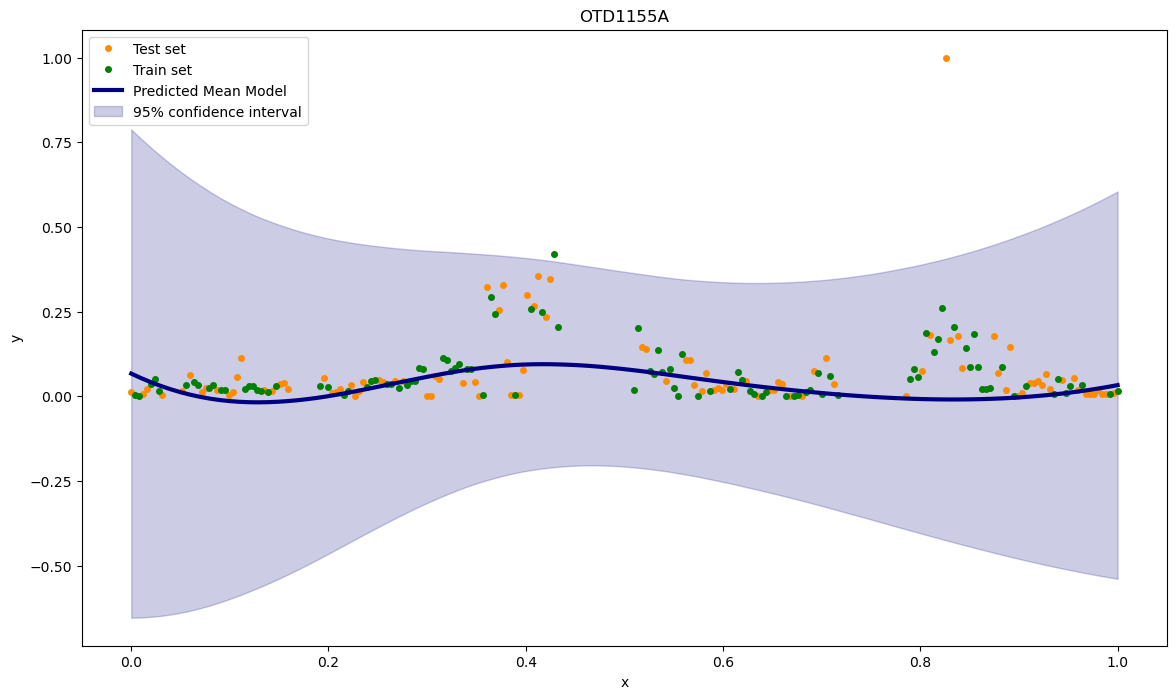

<Figure size 1400x800 with 0 Axes>

C:\Users\23478671\AppData\Local\Temp\ipykernel_16128\1501408209.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adt_Cu[['RL_mid_tf', 'Cu_pct']] = scaler.fit_transform(adt_Cu[['RL_mid_tf', 'Cu_pct']])


- MSE : 0.13, KL : 163.00


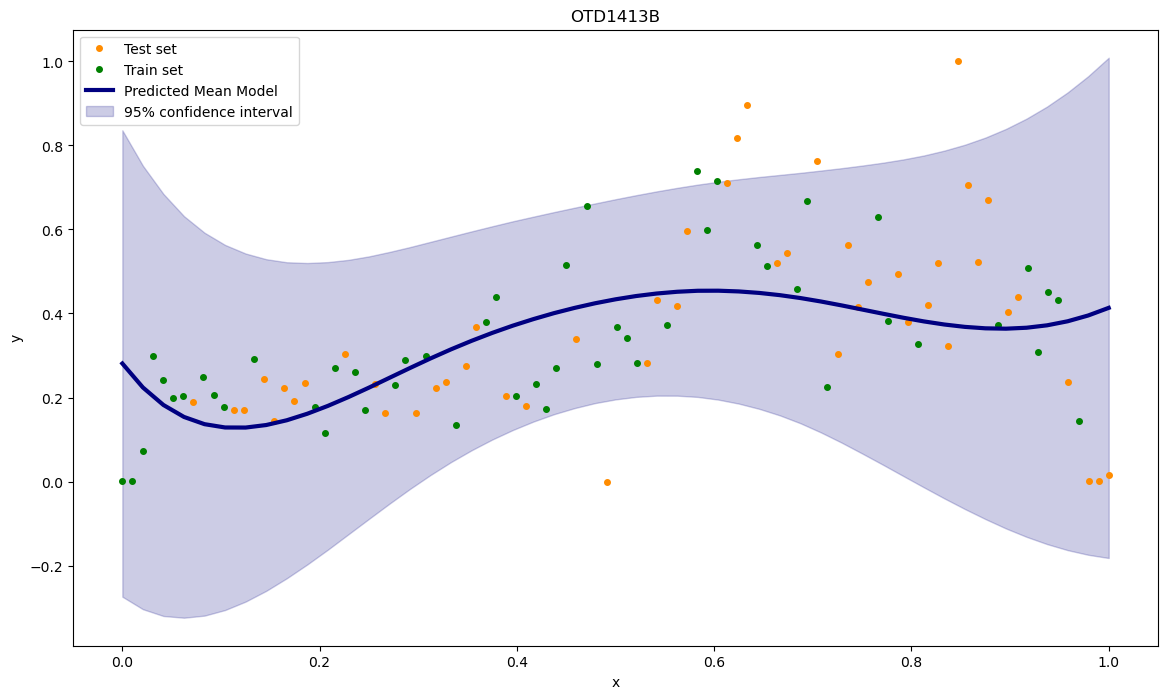

<Figure size 1400x800 with 0 Axes>

C:\Users\23478671\AppData\Local\Temp\ipykernel_16128\1501408209.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adt_Cu[['RL_mid_tf', 'Cu_pct']] = scaler.fit_transform(adt_Cu[['RL_mid_tf', 'Cu_pct']])


- MSE : 0.05, KL : 115.22


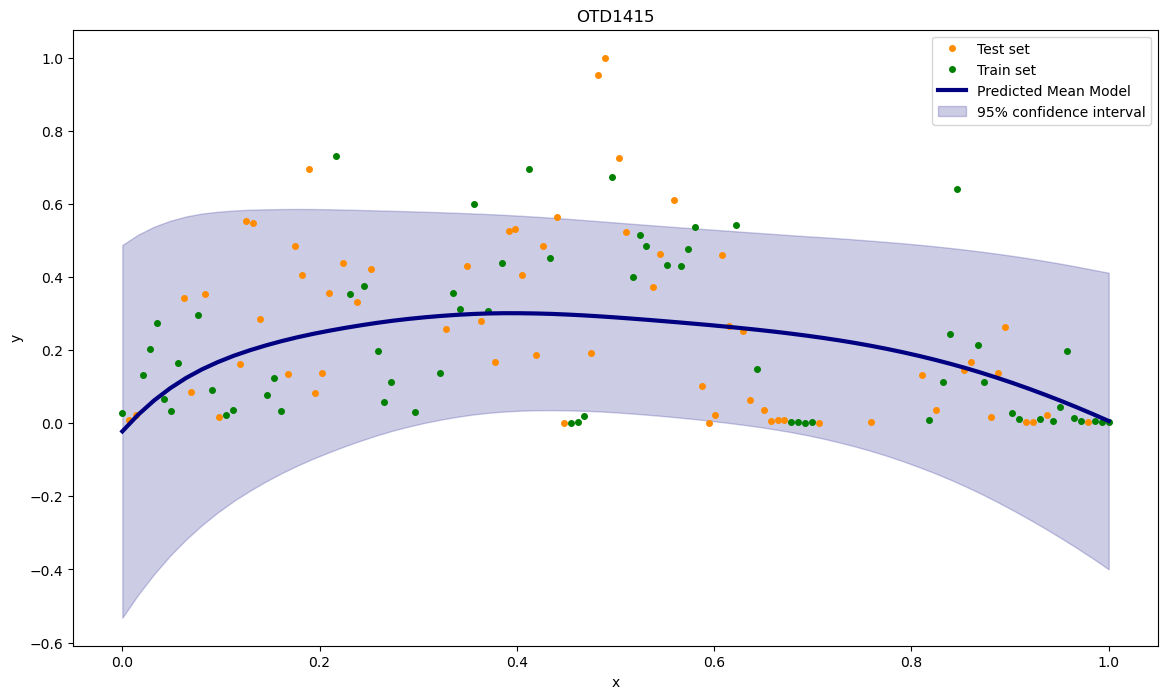

<Figure size 1400x800 with 0 Axes>

C:\Users\23478671\AppData\Local\Temp\ipykernel_16128\1501408209.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adt_Cu[['RL_mid_tf', 'Cu_pct']] = scaler.fit_transform(adt_Cu[['RL_mid_tf', 'Cu_pct']])


- MSE : 0.18, KL : 142.73


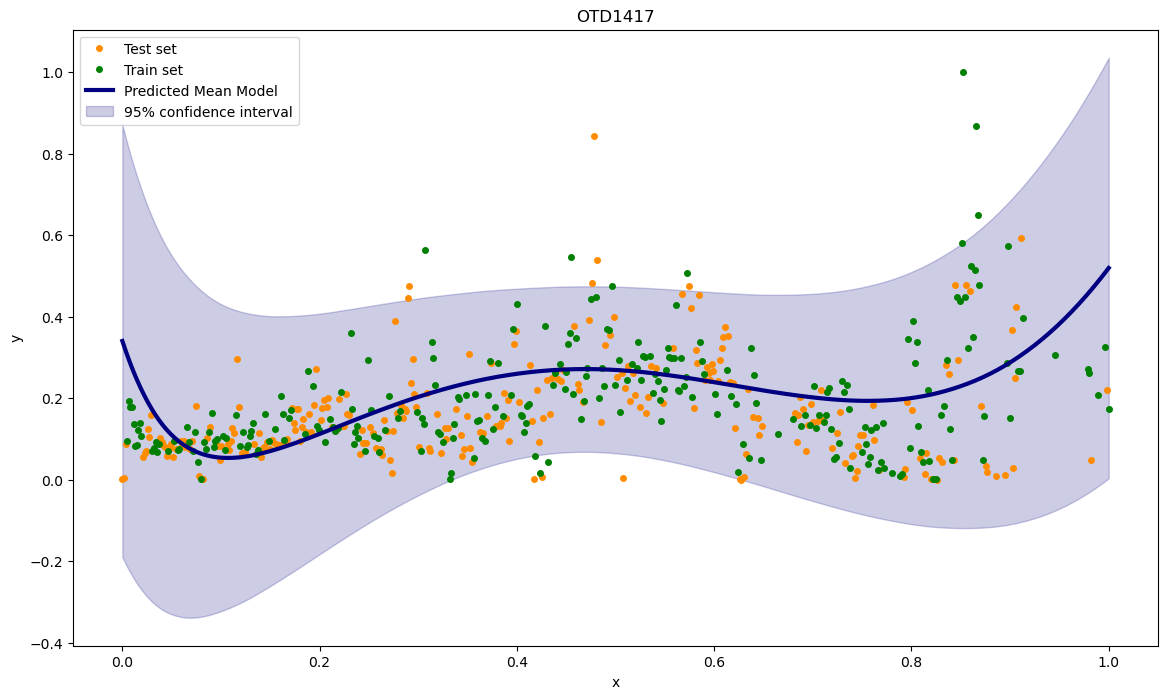

<Figure size 1400x800 with 0 Axes>

C:\Users\23478671\AppData\Local\Temp\ipykernel_16128\1501408209.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adt_Cu[['RL_mid_tf', 'Cu_pct']] = scaler.fit_transform(adt_Cu[['RL_mid_tf', 'Cu_pct']])


- MSE : 0.03, KL : 141.51


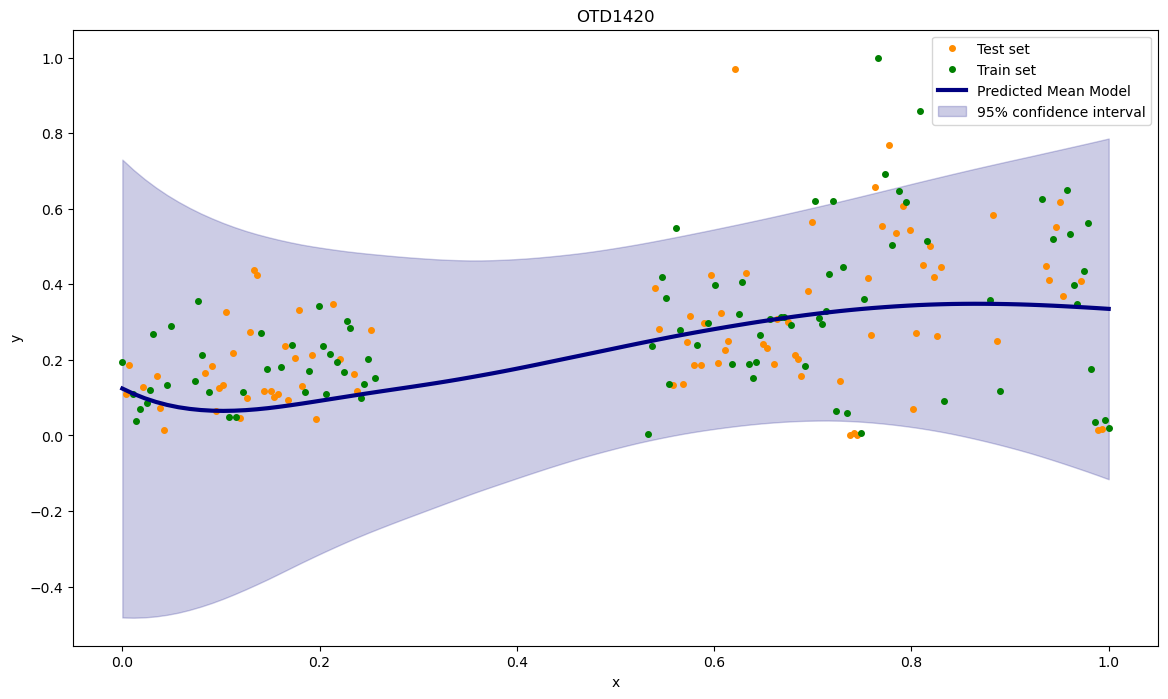

<Figure size 1400x800 with 0 Axes>

C:\Users\23478671\AppData\Local\Temp\ipykernel_16128\1501408209.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adt_Cu[['RL_mid_tf', 'Cu_pct']] = scaler.fit_transform(adt_Cu[['RL_mid_tf', 'Cu_pct']])


- MSE : 0.10, KL : 109.50


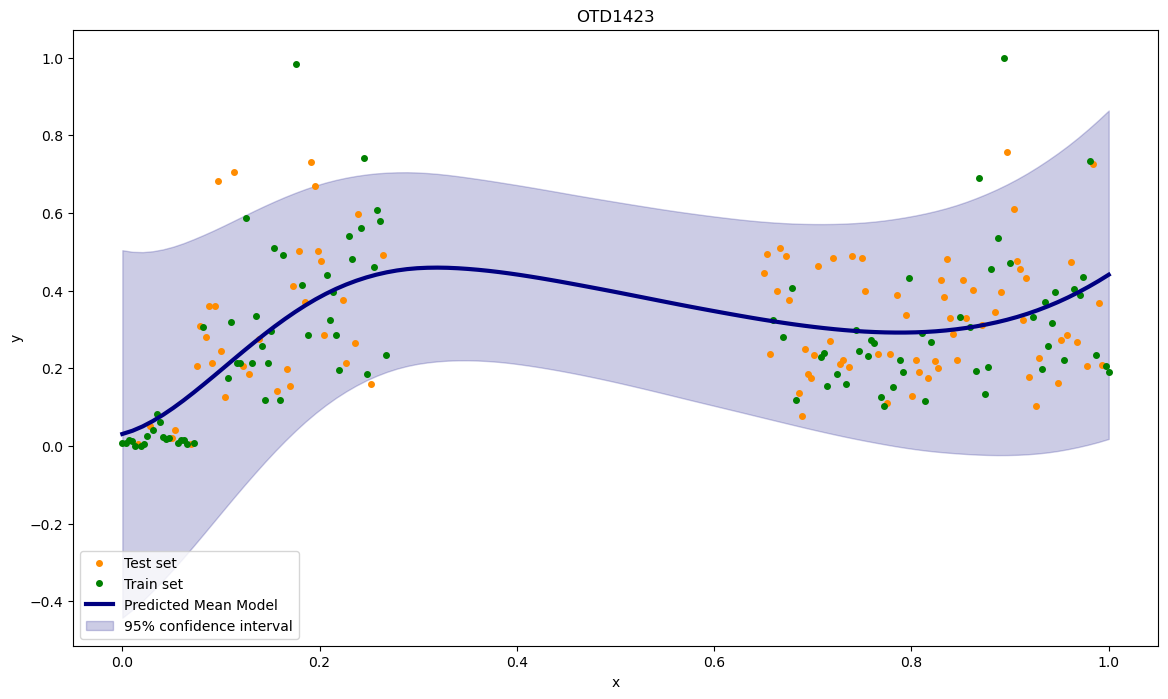

<Figure size 1400x800 with 0 Axes>

C:\Users\23478671\AppData\Local\Temp\ipykernel_16128\1501408209.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adt_Cu[['RL_mid_tf', 'Cu_pct']] = scaler.fit_transform(adt_Cu[['RL_mid_tf', 'Cu_pct']])


- MSE : 0.04, KL : 140.35


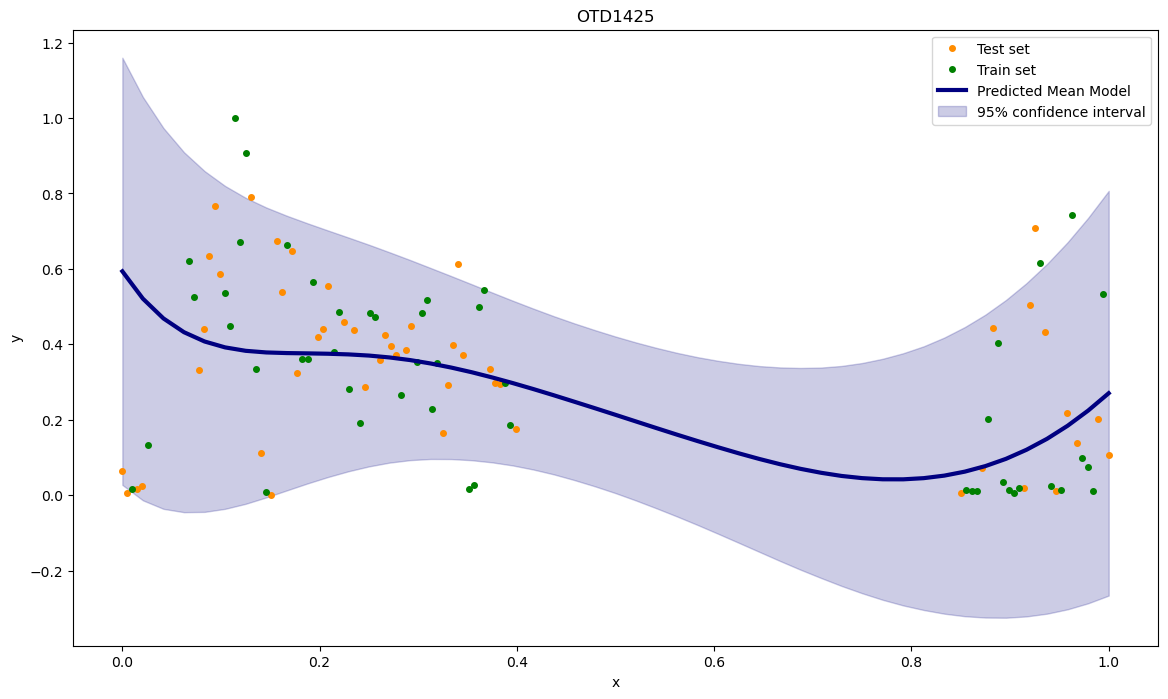

<Figure size 1400x800 with 0 Axes>

C:\Users\23478671\AppData\Local\Temp\ipykernel_16128\1501408209.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adt_Cu[['RL_mid_tf', 'Cu_pct']] = scaler.fit_transform(adt_Cu[['RL_mid_tf', 'Cu_pct']])


- MSE : 0.05, KL : 124.35


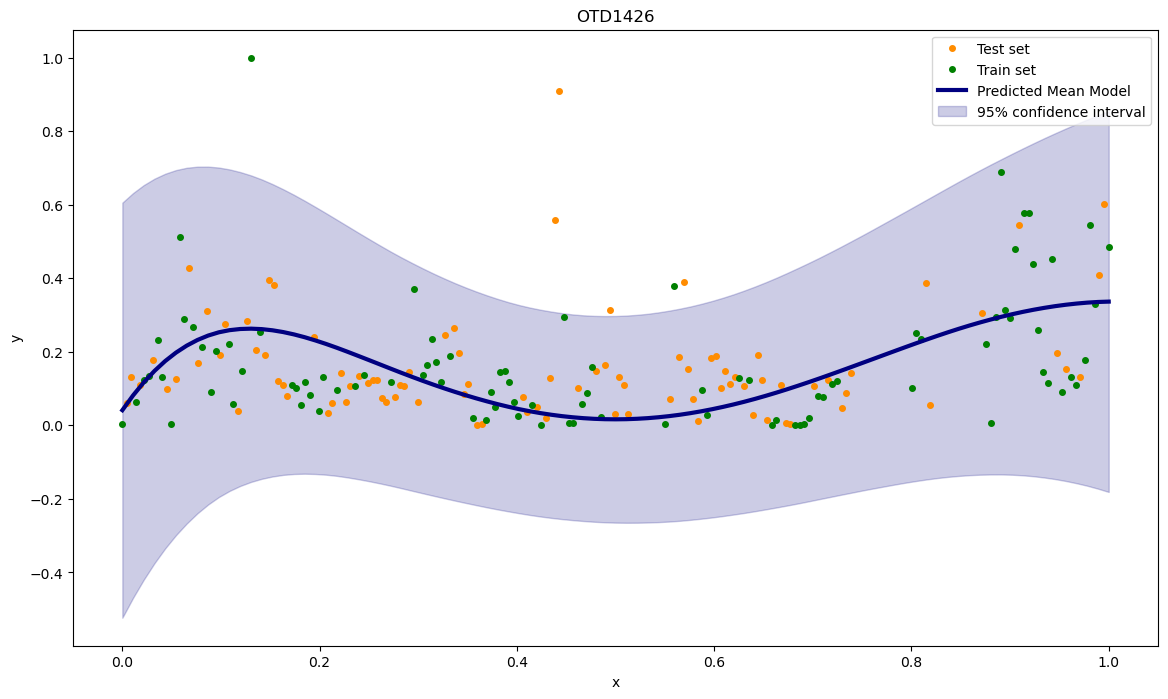

<Figure size 1400x800 with 0 Axes>

C:\Users\23478671\AppData\Local\Temp\ipykernel_16128\1501408209.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adt_Cu[['RL_mid_tf', 'Cu_pct']] = scaler.fit_transform(adt_Cu[['RL_mid_tf', 'Cu_pct']])


- MSE : 0.05, KL : 163.42


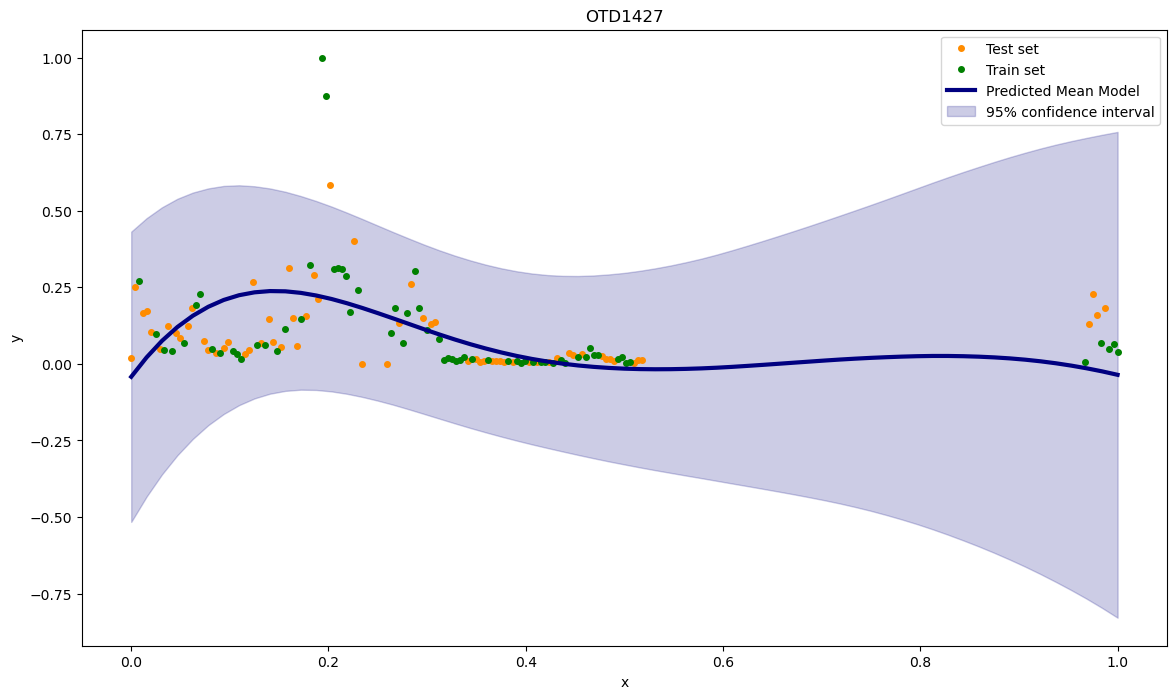

<Figure size 1400x800 with 0 Axes>

C:\Users\23478671\AppData\Local\Temp\ipykernel_16128\1501408209.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adt_Cu[['RL_mid_tf', 'Cu_pct']] = scaler.fit_transform(adt_Cu[['RL_mid_tf', 'Cu_pct']])


KeyboardInterrupt: 

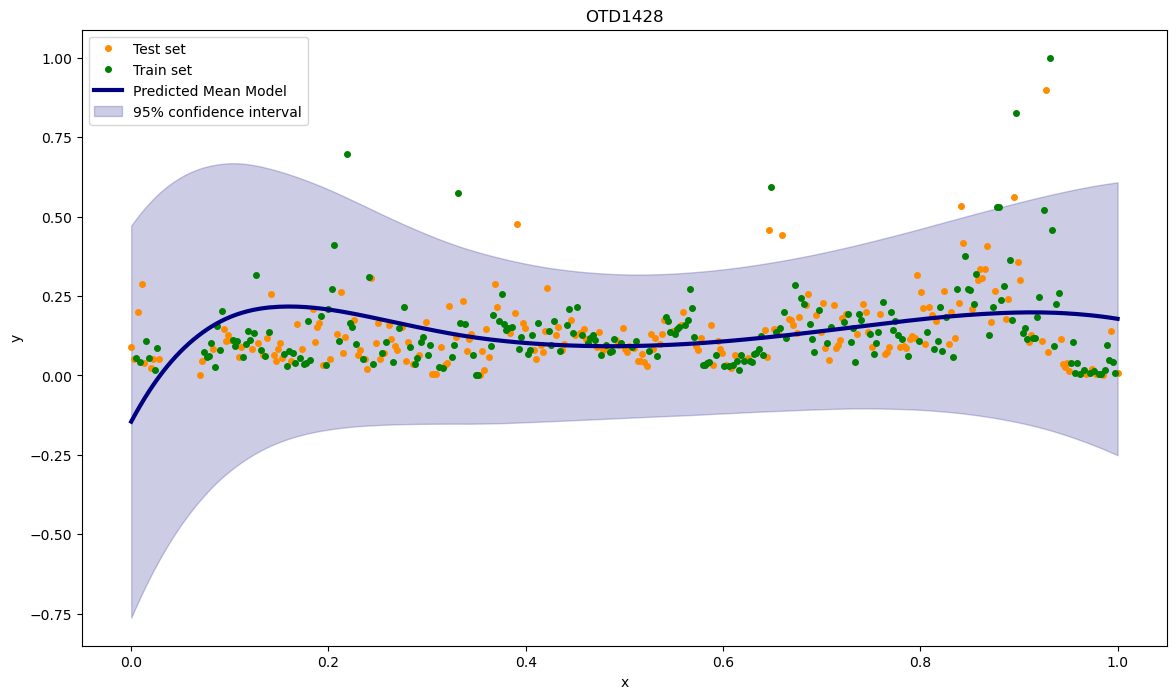

In [25]:
for hole in result['HOLEID'].unique():
    adt_Cu = adt_Cu2.loc[adt_Cu2['HOLEID'] == hole]

    from sklearn.preprocessing import MinMaxScaler

    # Create a MinMaxScaler instance
    scaler = MinMaxScaler()

    # Fit the scaler to your data and transform the specified columns
    adt_Cu[['RL_mid_tf', 'Cu_pct']] = scaler.fit_transform(adt_Cu[['RL_mid_tf', 'Cu_pct']])

    x = adt_Cu[['EAST_mid_tf','NORTH_mid_tf', 'RL_mid_tf']].values[:,np.newaxis] #[:,np.newaxis] makes the second dimension explicit
    y = adt_Cu[mineral].values[:,np.newaxis] #[:,np.newaxis] makes the second dimension explicit
    x = x.reshape(len(adt_Cu),3)
    x = x[:,2].reshape(-1,1)
    
    x = torch.tensor(x)
    y = torch.tensor(y)
    x = x.to(torch.float32)
    y = y.to(torch.float32)    
    # Determine the size of the test set (e.g., 20% of the data)
    test_size = int(0.5 * len(x))

    # Generate random indices for the test set
    test_indices = np.random.choice(len(x), size=test_size, replace=False)

    # Create train and test sets based on the indices
    x_train = x[np.setdiff1d(np.arange(len(x)), test_indices)]
    y_train = y[np.setdiff1d(np.arange(len(y)), test_indices)]

    x_test = x[np.sort(test_indices)]
    y_test = y[np.sort(test_indices)]

    model = nn.Sequential(
        bnn.BayesLinear(prior_mu=1, prior_sigma=0.08, in_features=1, out_features=1000),
        nn.ReLU(),
        bnn.BayesLinear(prior_mu=1, prior_sigma=0.08, in_features=1000, out_features=1),
    )

    mse_loss = nn.MSELoss()
    kl_loss = bnn.BKLLoss(reduction='mean', last_layer_only=False)
    kl_weight = 0.01

    optimizer = optim.SGD(model.parameters(), lr=0.01)

    for step in range(2000):
        pre = model(x_train)
        mse = mse_loss(pre, y_train)
        kl = kl_loss(model)
        cost = mse + kl_weight*kl
        
        optimizer.zero_grad()
        cost.backward()
        optimizer.step()
        
    print('- MSE : %2.2f, KL : %2.2f' % (mse.item(), kl.item()))

    import matplotlib.pyplot as plt
    #models_result = np.array([model(x_test).data.numpy() for k in range(1000)])
    original_tensor = torch.linspace(0, 1, len(x_test))

    # Reshape it to (170, 1)
    reshaped_tensor = original_tensor.view(len(x_test), 1)
    models_result = np.array([model(reshaped_tensor).data.numpy() for k in range(1000)])

    models_result = models_result[:,:,0]    
    models_result = models_result.T
    mean_values = np.array([models_result[i].mean() for i in range(len(models_result))])
    std_values = np.array([models_result[i].std() for i in range(len(models_result))])

    plt.figure(figsize=(14,8))
    #plt.scatter(x.data.numpy(), y.data.numpy(), s=4)
    plt.show()

    plt.figure(figsize=(14,8))
    plt.plot(x_test.data.numpy()[:,0],y_test.data.numpy()[:,0],'.',color='darkorange',markersize=8,label='Test set')
    plt.plot(x_train.data.numpy()[:,0],y_train.data.numpy()[:,0],'.',color='green',markersize=8,label='Train set')


    plt.plot(reshaped_tensor.data.numpy()[:,0],mean_values,color='navy',lw=3,label='Predicted Mean Model')
    plt.fill_between(reshaped_tensor.data.numpy()[:,0] ,mean_values-2.0*std_values,mean_values+2.0*std_values,alpha=0.2,color='navy',label='95% confidence interval')

    plt.legend()
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title(hole)